In [7]:
import pandas as pd
import numpy as np

from pathlib import Path


In [36]:
BASE = Path("../data")

ticker = "MS"
date = '2025-06-02'

quotes_fp_ms = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
q = pd.read_parquet(quotes_fp_ms)
q.head()

,ts,symbol,bid_price,ask_price,bid_size,ask_size,mid,spread,imbalance_l1,microprice,microprice_dev
0,2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
1,2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2,2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
3,2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355
4,2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355


## Merge data

In [42]:
BASE = Path("../data")

ticker = "SPY"
date = '2025-06-02'

quotes_fp_spy = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp_spy = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp_spy = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"

In [43]:
q = pd.read_parquet(quotes_fp_ms)
q.head()

,ts,symbol,bid_price,ask_price,bid_size,ask_size,mid,spread,imbalance_l1,microprice,microprice_dev
0,2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
1,2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2,2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
3,2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355
4,2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355


In [44]:
q = pd.read_parquet(quotes_fp_ms).set_index('ts').add_prefix("q_")
q.shape


(23399, 10)

In [45]:
q.head()

,q_symbol,q_bid_price,q_ask_price,q_bid_size,q_ask_size,q_mid,q_spread,q_imbalance_l1,q_microprice,q_microprice_dev
ts,,,,,,,,,,
2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.24,1.48,-0.5,126.870,-0.370
2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355
2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.27,1.42,-0.5,126.915,-0.355


In [46]:
q.columns

Index(['q_symbol', 'q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size',
       'q_mid', 'q_spread', 'q_imbalance_l1', 'q_microprice',
       'q_microprice_dev'],
      dtype='object')

In [81]:
def build_panel_1s(quotes_fp: Path, prices_fp: Path, trades_fp: Path) -> pd.DataFrame:
    q = pd.read_parquet(quotes_fp).set_index('ts').add_prefix("q_")
    p = pd.read_parquet(prices_fp).set_index('ts').add_prefix("p_")
    t = pd.read_parquet(trades_fp).set_index('ts').add_prefix("t_")

    # Inner join = only timestamps where all three exist
    panel = q.join(p, how="inner").join(t, how="inner")

    quote_cols = [c for c in panel.columns if c.startswith("q_")]
    panel[quote_cols] = panel[quote_cols].ffill()

    # Drop any rows that still have missing core state
    panel = panel.dropna(subset=["q_mid", "q_spread"])

    return panel


In [82]:
ticker = "MS"
quotes_fp = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"


panel = build_panel_1s(quotes_fp, prices_fp, trades_fp)
print(panel.shape)
print(panel.columns)
print(panel.head())


(23399, 23)
Index(['q_symbol', 'q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size',
       'q_mid', 'q_spread', 'q_imbalance_l1', 'q_microprice',
       'q_microprice_dev', 'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close',
       'p_volume', 'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades',
       't_vwap', 't_symbol'],
      dtype='object')
                          q_symbol  q_bid_price  q_ask_price  q_bid_size  \
ts                                                                         
2025-06-02 09:30:01-04:00       MS       126.50       127.98       200.0   
2025-06-02 09:30:02-04:00       MS       126.50       127.98       200.0   
2025-06-02 09:30:03-04:00       MS       126.50       127.98       200.0   
2025-06-02 09:30:04-04:00       MS       126.56       127.98       200.0   
2025-06-02 09:30:05-04:00       MS       126.56       127.98       200.0   

                           q_ask_size   q_mid  q_spread  q_imbalance_l1  \
ts                             

## Feature Engineering

In [83]:
panel.columns

Index(['q_symbol', 'q_bid_price', 'q_ask_price', 'q_bid_size', 'q_ask_size',
       'q_mid', 'q_spread', 'q_imbalance_l1', 'q_microprice',
       'q_microprice_dev', 'p_symbol', 'p_open', 'p_high', 'p_low', 'p_close',
       'p_volume', 'p_vwap', 'p_n_trades', 't_last', 't_volume', 't_n_trades',
       't_vwap', 't_symbol'],
      dtype='object')

In [84]:
# z-score regime window size
w = 300 # 5min

# add targets
panel['y_ret_5s'] = np.log(panel['q_mid']).shift(-5) - np.log(panel['q_mid'])
panel['y_ret_30s'] = np.log(panel['q_mid']).shift(-30) - np.log(panel['q_mid'])

# add features
panel['x_spread_bps'] = 1e4 * panel['q_spread'] / panel['q_mid']
panel['x_imb_l1'] = panel['q_imbalance_l1']
panel['x_mp_dev'] = panel['q_microprice_dev']

# trade intensity + volume shocks
panel["x_ntrades"] = panel["t_n_trades"]
panel["x_volume"] = panel["t_volume"]

panel['x_ntrades_z'] = (panel['x_ntrades'] - panel['x_ntrades'].rolling(w).mean()) / panel['x_ntrades'].rolling(w).std()
panel['x_volume_z'] = (panel['x_volume'] - panel['x_volume'].rolling(w).mean()) / panel['x_volume'].rolling(w).std()

# vwap pressure
panel["x_vwap_mid_bps"] = 1e4 * (panel["t_vwap"] - panel["q_mid"]) / panel["q_mid"]

# short-horizon vol regime
panel["x_ret_1s"] = np.log(panel["q_mid"]).diff()
panel["x_realized_vol_30s"] = panel["x_ret_1s"].rolling(30).std()

# quote update
panel["x_quote_update"] = (
    (panel["q_bid_price"].diff() != 0) | (panel["q_ask_price"].diff() != 0)
).astype(int)
panel["x_quote_update_30s"] = panel["x_quote_update"].rolling(30).mean()

feat_cols = [c for c in panel.columns if c.startswith("x_")]
target_cols = ["y_ret_5s", "y_ret_30s"]

df = panel.dropna(subset=feat_cols + target_cols).copy()



In [85]:
panel

,q_symbol,q_bid_price,q_ask_price,q_bid_size,q_ask_size,q_mid,q_spread,q_imbalance_l1,q_microprice,q_microprice_dev,...,x_mp_dev,x_ntrades,x_volume,x_ntrades_z,x_volume_z,x_vwap_mid_bps,x_ret_1s,x_realized_vol_30s,x_quote_update,x_quote_update_30s
ts,,,,,,,,,,,,,,,,,,,,,
2025-06-02 09:30:01-04:00,MS,126.50,127.98,200.0,600.0,127.240,1.48,-0.500000,126.870000,-0.370000,...,-0.370000,12,323,NaN,NaN,-21.465493,NaN,NaN,1,NaN
2025-06-02 09:30:02-04:00,MS,126.50,127.98,200.0,600.0,127.240,1.48,-0.500000,126.870000,-0.370000,...,-0.370000,6,6,NaN,NaN,-3.667610,0.000000,NaN,0,NaN
2025-06-02 09:30:03-04:00,MS,126.50,127.98,200.0,600.0,127.240,1.48,-0.500000,126.870000,-0.370000,...,-0.370000,1,4,NaN,NaN,-20.433826,0.000000,NaN,0,NaN
2025-06-02 09:30:04-04:00,MS,126.56,127.98,200.0,600.0,127.270,1.42,-0.500000,126.915000,-0.355000,...,-0.355000,1,1,NaN,NaN,35.357901,0.000236,NaN,1,NaN
2025-06-02 09:30:05-04:00,MS,126.56,127.98,200.0,600.0,127.270,1.42,-0.500000,126.915000,-0.355000,...,-0.355000,2,12,NaN,NaN,32.607842,0.000000,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02 15:59:55-04:00,MS,128.38,128.41,800.0,300.0,128.395,0.03,0.454545,128.401818,0.006818,...,0.006818,18,496,0.181315,-0.360142,-0.012562,0.000000,0.000096,0,0.733333
2025-06-02 15:59:56-04:00,MS,128.41,128.43,100.0,400.0,128.420,0.02,-0.600000,128.414000,-0.006000,...,-0.006000,52,2726,2.196858,1.414328,-0.830541,0.000195,0.000100,1,0.733333
2025-06-02 15:59:57-04:00,MS,128.41,128.44,100.0,2700.0,128.425,0.03,-0.928571,128.411071,-0.013929,...,-0.013929,82,4585,3.872552,2.848262,0.091758,0.000039,0.000100,1,0.733333


## Predictability Test

In [86]:
feat_cols = [c for c in df.columns if c.startswith("x_")]

ic_5s = df[feat_cols].corrwith(df["y_ret_5s"], method="spearman")
ic_30s = df[feat_cols].corrwith(df["y_ret_30s"], method="spearman")


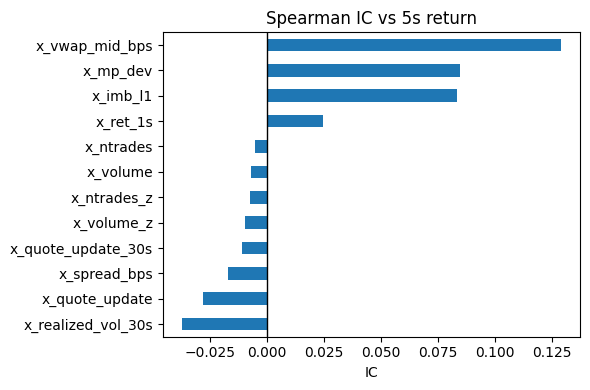

In [87]:
import matplotlib.pyplot as plt

# Spearman Information Coefficient

ic_5s.sort_values().plot(kind="barh", figsize=(6,4))
plt.axvline(0, color="black", linewidth=1)
plt.title("Spearman IC vs 5s return")
plt.xlabel("IC")
plt.tight_layout()
plt.show()


- top-of-the-book imbalance seems to be reflecting the return after 5s strongly.
- microprice deviation also reflects strong positive correlation with 5s return.

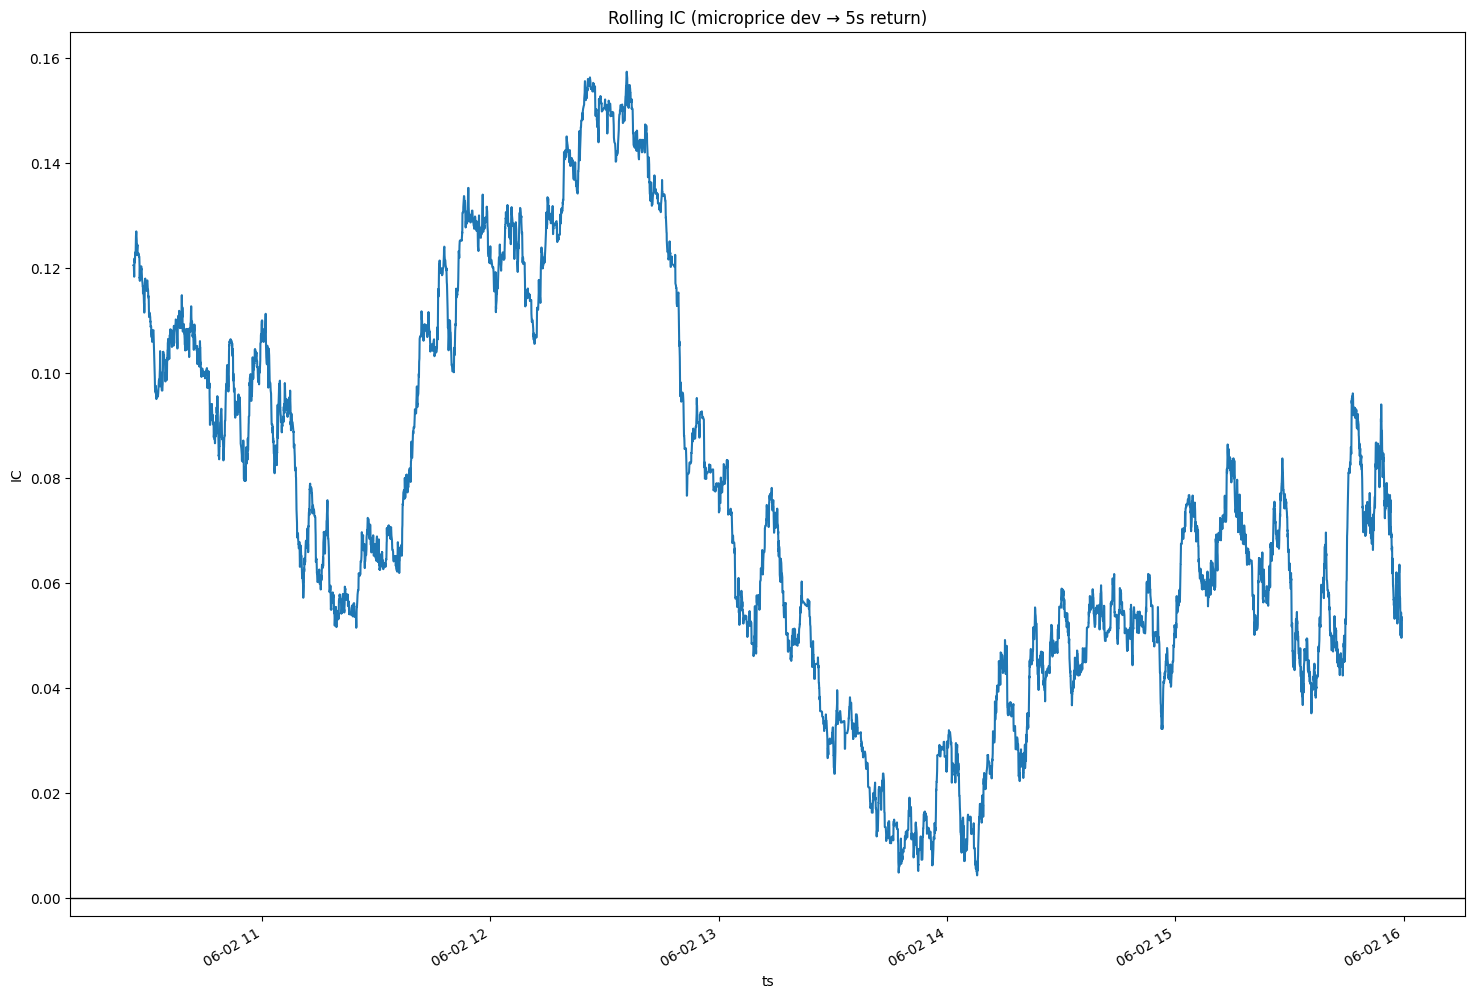

In [88]:
def rolling_ic(x, y, window):
    window = 1800  # e.g. 30 minutes at 1s

    x_rank = x.rank()
    y_rank = y.rank()

    rolling_ic = x_rank.rolling(window).corr(y_rank)
    return rolling_ic

ic_ts = rolling_ic(df["x_mp_dev"], df["y_ret_5s"], window=1800)  # 30 min

ic_ts.plot(figsize=(18,13))
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling IC (microprice dev → 5s return)")
plt.ylabel("IC")
plt.show()


## Horizon Decay

In [89]:
ics = {}

horizons = [1, 5, 10, 20, 30, 60] # seconds

for h in horizons:
    y = np.log(df['q_mid'].shift(-h)) - np.log(df['q_mid'])
    ics[h] = df['x_imb_l1'].corr(y, method='spearman')

ic_decay = pd.Series(ics)


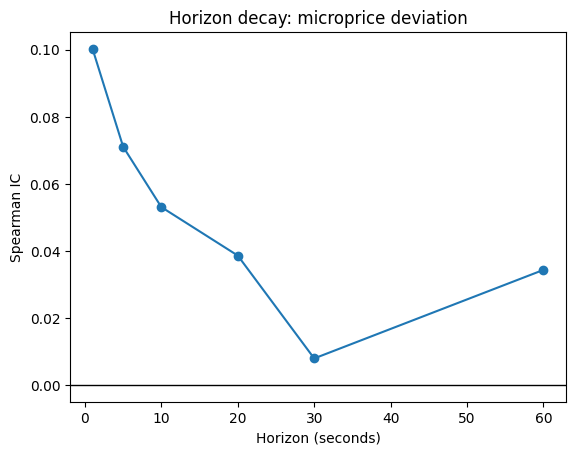

In [90]:
ic_decay.plot(marker="o")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Horizon (seconds)")
plt.ylabel("Spearman IC")
plt.title("Horizon decay: microprice deviation")
plt.show()


## Rel Val

In [91]:
BASE = Path("../data")

ticker = "MS"
date = '2025-06-02'

quotes_fp_gs = BASE / "quotes" / f"{ticker}_quotes_1s_{date}.parquet"
prices_fp_gs = BASE / "prices" / f"{ticker}_1s_{date}.parquet"
trades_fp_gs = BASE / "trades" / f"{ticker}_trades_1s_{date}.parquet"

df = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
df = df[['q_mid']]
df

,q_mid
ts,
2025-06-02 09:30:01-04:00,127.240
2025-06-02 09:30:02-04:00,127.240
2025-06-02 09:30:03-04:00,127.240
2025-06-02 09:30:04-04:00,127.270
2025-06-02 09:30:05-04:00,127.270
...,...
2025-06-02 15:59:55-04:00,128.395
2025-06-02 15:59:56-04:00,128.420
2025-06-02 15:59:57-04:00,128.425


In [92]:
quotes_fp_gs = BASE / "quotes" / f"SPY_quotes_1s_{date}.parquet"
prices_fp_gs = BASE / "prices" / f"SPY_1s_{date}.parquet"
trades_fp_gs = BASE / "trades" / f"SPY_trades_1s_{date}.parquet"
df_market = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
df_market = df_market[['q_mid']]
df_market

,q_mid
ts,
2025-06-02 09:30:00-04:00,587.915
2025-06-02 09:30:01-04:00,588.090
2025-06-02 09:30:02-04:00,588.145
2025-06-02 09:30:03-04:00,588.025
2025-06-02 09:30:04-04:00,588.055
...,...
2025-06-02 15:59:55-04:00,592.545
2025-06-02 15:59:56-04:00,592.645
2025-06-02 15:59:57-04:00,592.725


In [93]:
ts = df.index.intersection(df_market.index)
ts

DatetimeIndex(['2025-06-02 09:30:01-04:00', '2025-06-02 09:30:02-04:00',
               '2025-06-02 09:30:03-04:00', '2025-06-02 09:30:04-04:00',
               '2025-06-02 09:30:05-04:00', '2025-06-02 09:30:06-04:00',
               '2025-06-02 09:30:07-04:00', '2025-06-02 09:30:08-04:00',
               '2025-06-02 09:30:09-04:00', '2025-06-02 09:30:10-04:00',
               ...
               '2025-06-02 15:59:50-04:00', '2025-06-02 15:59:51-04:00',
               '2025-06-02 15:59:52-04:00', '2025-06-02 15:59:53-04:00',
               '2025-06-02 15:59:54-04:00', '2025-06-02 15:59:55-04:00',
               '2025-06-02 15:59:56-04:00', '2025-06-02 15:59:57-04:00',
               '2025-06-02 15:59:58-04:00', '2025-06-02 15:59:59-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='ts', length=23399, freq='s')

In [94]:
df, df_market = df.loc[ts], df_market.loc[ts]
print(df.shape, df_market.shape)

(23399, 1) (23399, 1)


In [95]:
df.rename(columns={'q_mid': 'gs_mid'}, inplace=True)
df_market.rename(columns={'q_mid': 'spy_mid'}, inplace=True)

In [96]:
df_merged = df.join(df_market, how='left')
df_merged.reset_index(inplace=True)
df_merged

,ts,gs_mid,spy_mid
0,2025-06-02 09:30:01-04:00,127.240,588.090
1,2025-06-02 09:30:02-04:00,127.240,588.145
2,2025-06-02 09:30:03-04:00,127.240,588.025
3,2025-06-02 09:30:04-04:00,127.270,588.055
4,2025-06-02 09:30:05-04:00,127.270,588.185
...,...,...,...
23394,2025-06-02 15:59:55-04:00,128.395,592.545
23395,2025-06-02 15:59:56-04:00,128.420,592.645
23396,2025-06-02 15:59:57-04:00,128.425,592.725
23397,2025-06-02 15:59:58-04:00,128.435,592.760


In [97]:
EPS = 1e-12
window = 300

def ols_alpha_beta(y, x):
    y_bar = y.mean()
    x_bar = x.mean()
    
    dx = x - x_bar
    dy = y - y_bar 

    var_x = (dx*dx).mean()
    if var_x < EPS:
        return 0.0, 0.0
    cov_xy = (dy*dx).mean()

    beta = cov_xy / (var_x + EPS)
    alpha = y_bar - beta * x_bar
    
    return alpha, beta



In [98]:
signals = []
base_size = 50
current_qty = 0

for i in range(window+1, len(df_merged)):
    dfw = df_merged.iloc[i-(window+1):i]
    r_m = np.log(dfw["spy_mid"]).diff().dropna()
    r  = np.log(dfw["gs_mid"]).diff().dropna()

    a, b = ols_alpha_beta(r, r_m)
    
    eps = r - (a + b * r_m)
    sigma_eps = eps.std(ddof=1)
    z = float((eps.iloc[-1] - eps.mean()) / (sigma_eps + 1e-12)) if sigma_eps > 1e-12 else 0.0

    if z > 2.0:
        signals.append((z,))
    elif z < -2.0:
        signals.append((z,))
    else:
        continue
    
    if abs(z) < 0.5:
        signals.append((z,))
    else:
        continue
    

len(signals)

1180

## Pairs Trading

In [127]:
BASE = Path("../data")

tickers = ["GS", "MS"]
date = '2025-06-02'

df_dict = {}
for sym in tickers:
    quotes_fp_gs = BASE / "quotes" / f"{sym}_quotes_1s_{date}.parquet"
    prices_fp_gs = BASE / "prices" / f"{sym}_1s_{date}.parquet"
    trades_fp_gs = BASE / "trades" / f"{sym}_trades_1s_{date}.parquet"

    panel = build_panel_1s(quotes_fp=quotes_fp_gs, prices_fp=prices_fp_gs, trades_fp=trades_fp_gs)
    df_dict[sym] = panel['q_mid']

df = pd.DataFrame(df_dict).dropna()
df

,GS,MS
ts,,
2025-06-02 09:30:01-04:00,597.850,127.240
2025-06-02 09:30:02-04:00,597.730,127.240
2025-06-02 09:30:03-04:00,597.715,127.240
2025-06-02 09:30:04-04:00,597.755,127.270
2025-06-02 09:30:05-04:00,597.750,127.270
...,...,...
2025-06-02 15:59:55-04:00,598.660,128.395
2025-06-02 15:59:56-04:00,598.725,128.420
2025-06-02 15:59:57-04:00,598.775,128.425


In [129]:
# signals
df['ret_GS_1s'] = np.log(df['GS']).diff()
df['ret_MS_1s'] = np.log(df['MS']).diff()

df.dropna(inplace=True)
df


,GS,MS,ret_GS_1s,ret_MS_1s
ts,,,,
2025-06-02 09:30:02-04:00,597.730,127.240,-0.000201,0.000000
2025-06-02 09:30:03-04:00,597.715,127.240,-0.000025,0.000000
2025-06-02 09:30:04-04:00,597.755,127.270,0.000067,0.000236
2025-06-02 09:30:05-04:00,597.750,127.270,-0.000008,0.000000
2025-06-02 09:30:06-04:00,597.740,127.270,-0.000017,0.000000
...,...,...,...,...
2025-06-02 15:59:55-04:00,598.660,128.395,0.000200,0.000000
2025-06-02 15:59:56-04:00,598.725,128.420,0.000109,0.000195
2025-06-02 15:59:57-04:00,598.775,128.425,0.000084,0.000039


### OLS

Finding rolling hedge ration of $r_{t}^{GS} = \alpha + \beta*r_{t}^{MS} + \epsilon_t $

In [136]:
def ols_alpha_beta_rolling(y: pd.Series, x: pd.Series, window: int = 300):
    y = y.astype(float)
    x = x.astype(float)

    x_bar = x.rolling(window).mean()
    y_bar = y.rolling(window).mean()
    dx = x - x_bar
    dy = y - y_bar

    var_x = (dx*dx).rolling(window).mean()
    cov_xy = (dx*dy).rolling(window).mean()

    b = cov_xy / var_x
    a = y_bar - b*x_bar
    eps = y - a - b * x

    return pd.DataFrame({
        "alpha": a,
        "beta": b,
        "eps": eps
    })

In [ ]:
df_hedge = ols_alpha_beta_rolling(df['ret_GS_1s'], df['ret_MS_1s'])
df_hedge

,alpha,beta,eps
ts,,,
2025-06-02 09:30:02-04:00,NaN,NaN,NaN
2025-06-02 09:30:03-04:00,NaN,NaN,NaN
2025-06-02 09:30:04-04:00,NaN,NaN,NaN
2025-06-02 09:30:05-04:00,NaN,NaN,NaN
2025-06-02 09:30:06-04:00,NaN,NaN,NaN
...,...,...,...
2025-06-02 15:59:55-04:00,0.000002,0.367642,0.000199
2025-06-02 15:59:56-04:00,0.000002,0.373508,0.000034
2025-06-02 15:59:57-04:00,0.000002,0.375526,0.000067


**Coefficient Variation (CV) / rolling beta std instability episodic test / Smoothness test**

In [ ]:
W = 300

df_hedge['beta_std_5m'] = df_hedge['beta'].rolling(W).std()
df_hedge

,alpha,beta,eps,beta_std_5m
ts,,,,
2025-06-02 09:30:02-04:00,NaN,NaN,NaN,NaN
2025-06-02 09:30:03-04:00,NaN,NaN,NaN,NaN
2025-06-02 09:30:04-04:00,NaN,NaN,NaN,NaN
2025-06-02 09:30:05-04:00,NaN,NaN,NaN,NaN
2025-06-02 09:30:06-04:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-06-02 15:59:55-04:00,0.000002,0.367642,0.000199,0.037224
2025-06-02 15:59:56-04:00,0.000002,0.373508,0.000034,0.037540
2025-06-02 15:59:57-04:00,0.000002,0.375526,0.000067,0.037866


Text(0, 0.5, 'rolling bet std 5m')

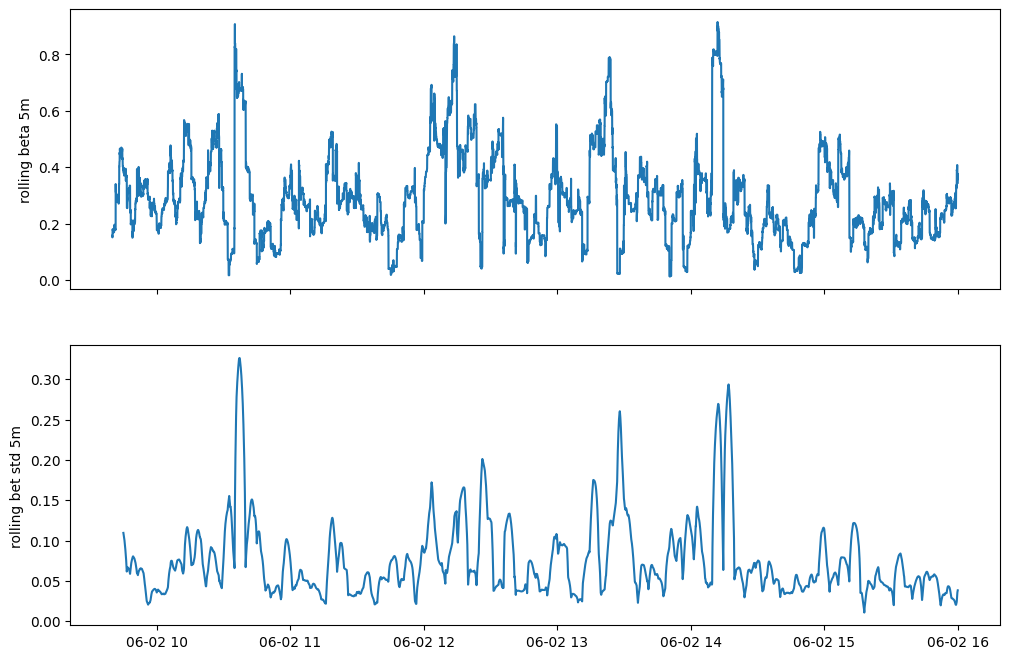

In [149]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax1.plot(df_hedge['beta'])
ax2.plot(df_hedge['beta_std_5m'])

ax1.set_ylabel('rolling beta 5m')
ax2.set_ylabel('rolling bet std 5m')

1) beta CV

In [153]:
# beta CV
beta_mean = df_hedge['beta'].mean()
beta_std  = df_hedge['beta'].std()
cv_beta = beta_std / abs(beta_mean)

cv_beta

0.5269467515131959

> beta is highly unstable -> seems to be regime driven relationship

2. beta std instability episodic test


In [ ]:
q80 = df_hedge['beta_std_5m'].quantile(0.8)
unstable_frac = (df_hedge['beta_std_5m'] > q80).mean()
unstable_frac

0.19232413026754425

> acceptable level of beta std

3. Smoothness test (check risky jump)

In [161]:
db = df_hedge['beta'].diff()
jump_rate = (db.abs() > 3 * db.std()).mean()
jump_rate

0.013804598683648176

> rare jump

4. Sanity checkt

In [163]:
df_hedge[['beta_std_5m', 'eps']].corr()


,beta_std_5m,eps
beta_std_5m,1.000000,-0.006316
eps,-0.006316,1.000000
